In [1]:

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.preprocessing import TargetEncoder
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

# Загрузим данные

In [2]:
train_df = pd.read_csv('train.csv')

test_df = pd.read_csv('test.csv')


# Проанализируем данные

In [3]:
train_df.isna().sum()

,0
id,0
vendor_id,0
pickup_datetime,0
dropoff_datetime,0
passenger_count,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
store_and_fwd_flag,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021050 entries, 0 to 1021049
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1021050 non-null  object 
 1   vendor_id           1021050 non-null  int64  
 2   pickup_datetime     1021050 non-null  object 
 3   dropoff_datetime    1021050 non-null  object 
 4   passenger_count     1021050 non-null  int64  
 5   pickup_longitude    1021050 non-null  float64
 6   pickup_latitude     1021050 non-null  float64
 7   dropoff_longitude   1021050 non-null  float64
 8   dropoff_latitude    1021050 non-null  float64
 9   store_and_fwd_flag  1021050 non-null  object 
 10  trip_duration       1021050 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 85.7+ MB


In [5]:
train_df['passenger_count'].value_counts()

,count
passenger_count,
1,723614
2,147429
5,54532
3,41919
6,33707
4,19804
0,41
7,2
8,1


Пропущенных значений нет, распределение целевой переменной логнормальное

<Axes: xlabel='trip_duration', ylabel='Count'>

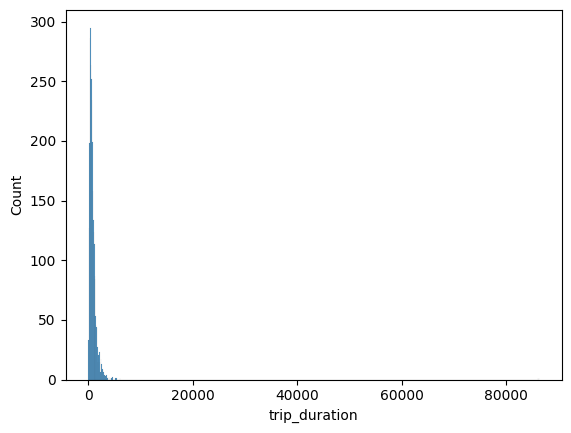

In [6]:
sns.histplot(train_df[:3000], x='trip_duration')

In [7]:
train_df = train_df.drop('id', axis=1)

Поскольку в тесте нету dropoff_datetime , уберем его

In [8]:
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])

train_df['day'] = train_df['pickup_datetime'].dt.day_name()

train_df['pickup_hour'] = train_df['pickup_datetime'].dt.round('h').dt.hour

train_df = train_df.drop(['dropoff_datetime', 'pickup_datetime'], axis=1)

Посмотрим на широту и долготу

<Axes: xlabel='dropoff_latitude', ylabel='dropoff_longitude'>

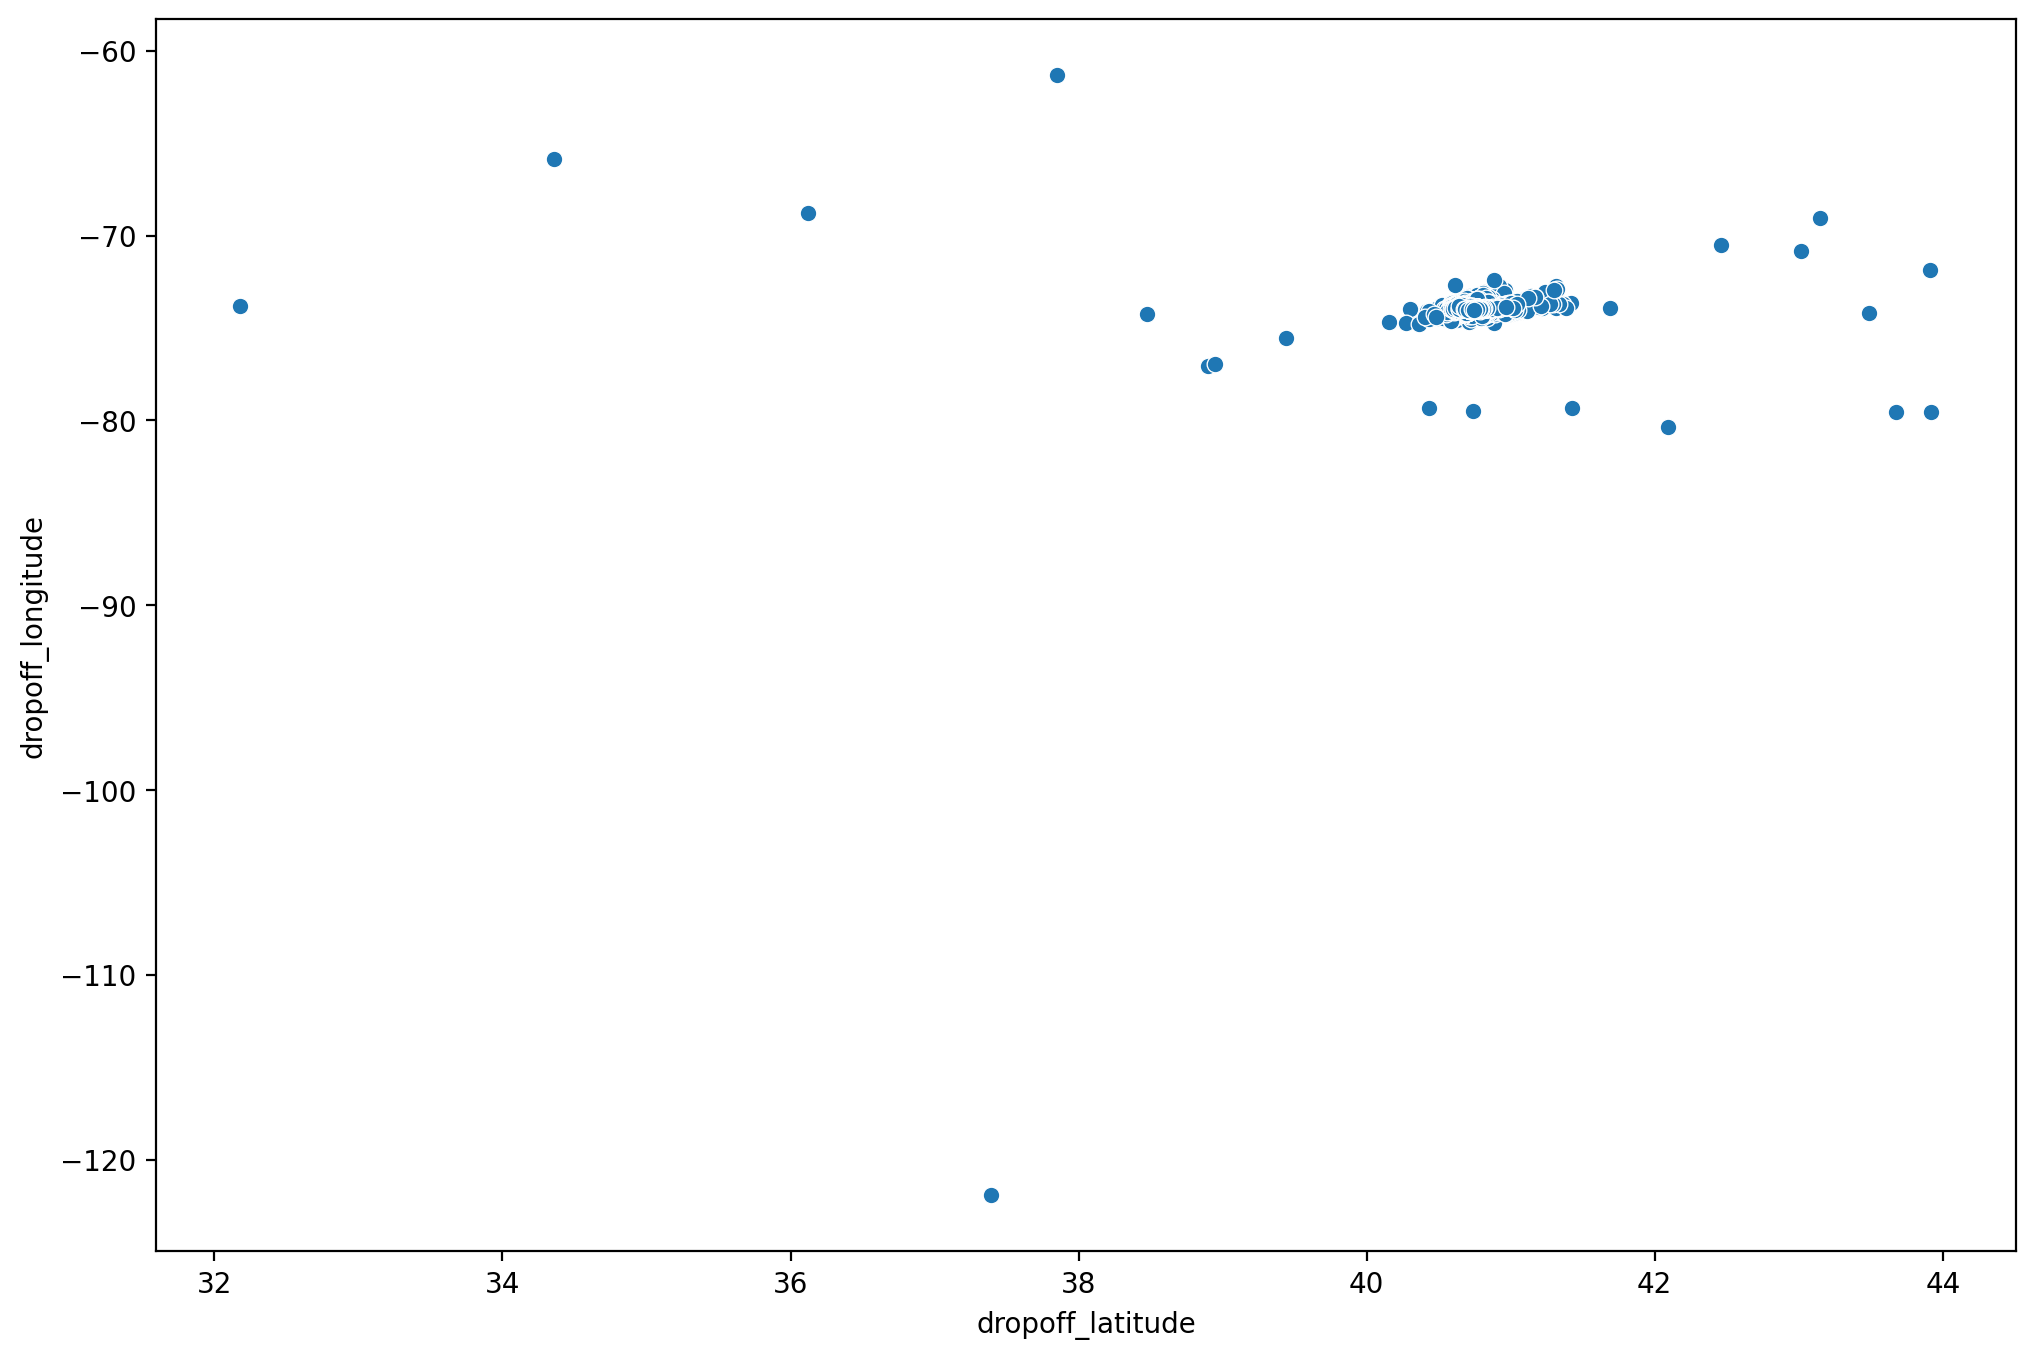

In [9]:
plt.figure(figsize=(12,8), dpi=200)
sns.scatterplot(data=train_df, x='dropoff_latitude', y='dropoff_longitude')


<Axes: xlabel='pickup_latitude', ylabel='pickup_longitude'>

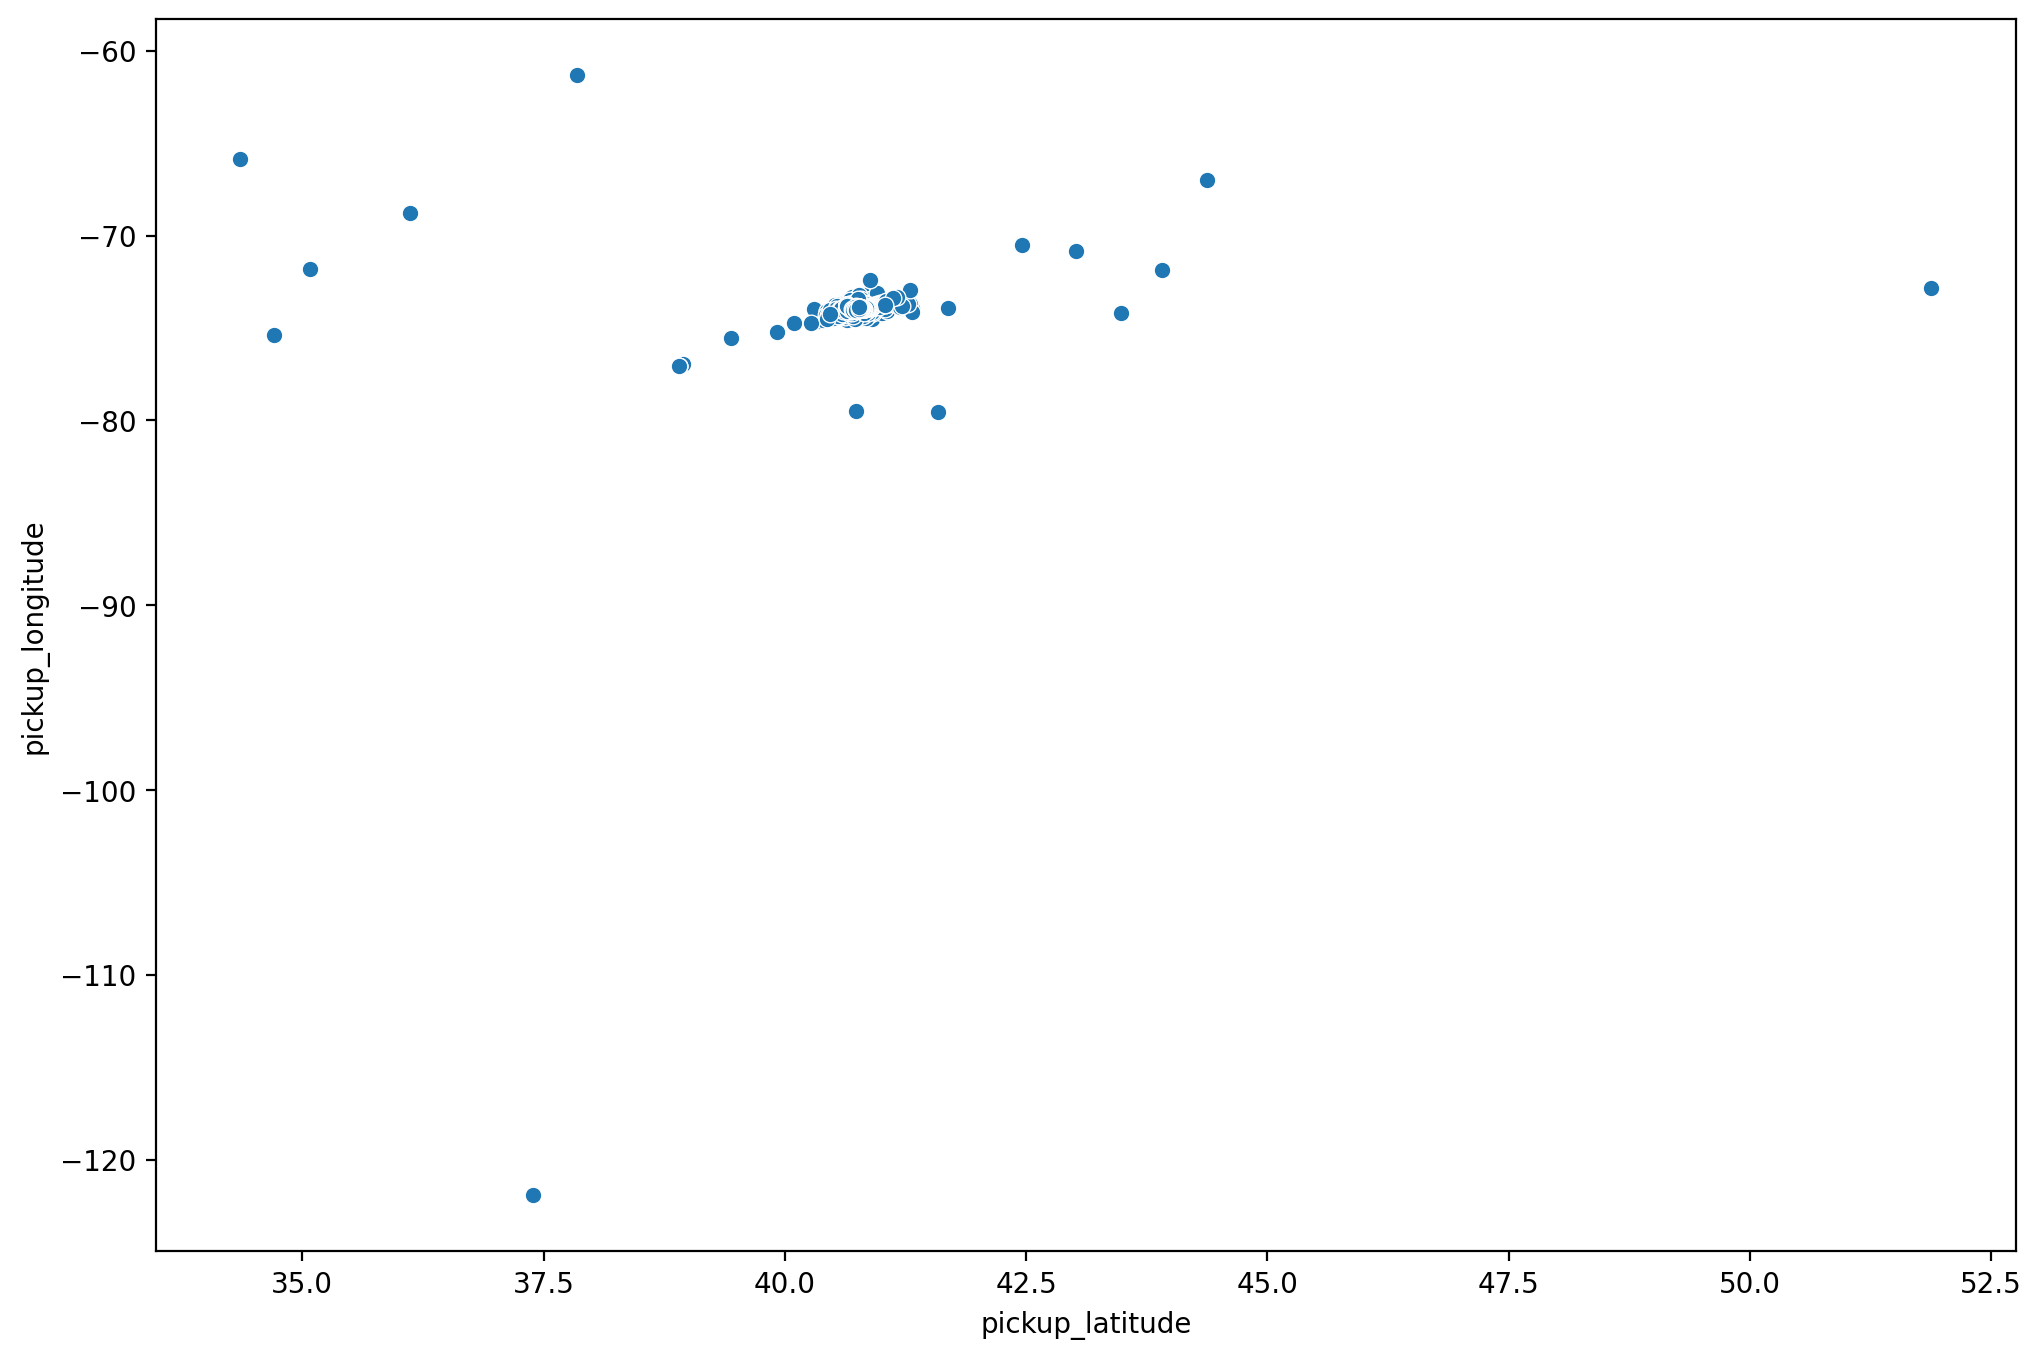

In [10]:
plt.figure(figsize=(12,8), dpi=200)
sns.scatterplot(data=train_df, x='pickup_latitude', y='pickup_longitude')


# Работа с выбросами и добавление расстояния

Посмотрим на реальные широту и долготу Нью-Йорка:

Широта-  от 40.477 до 40.917
Долгота- от -74.259 до -73.700

Значит нужно убрать выбросы как из широты и долготы , так и из таргета

In [11]:
train_df = train_df[(train_df['dropoff_longitude'] > -74.259) & (train_df['dropoff_longitude'] < -73.7) &
    (train_df['pickup_longitude'] > -74.259) & (train_df['pickup_longitude'] < -73.7) &
    (train_df['dropoff_latitude'] > 40.477) & (train_df['dropoff_latitude'] < 40.917) &
     (train_df['pickup_latitude'] > 40.477) & (train_df['pickup_latitude'] < 40.917) ]

In [12]:
train_df = train_df.query('trip_duration < 9000')


Добавим манхетонское расстояние

In [13]:
train_df['manhattan_distance'] = (abs(train_df['pickup_longitude'] - train_df['dropoff_longitude']) +
                             abs(train_df['pickup_latitude'] - train_df['dropoff_latitude']))

In [14]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.6 MB/s eta 0:00:00


# Обучение

Теперь будем обучать, избавимся от лог-нормального рспределения прологарифмировав целевую переменную а затем будем делать обратную операцию при вычислении метрики. Попробуем target_encoder для кодирования и Lasso

In [15]:
X = train_df.drop('trip_duration', axis=1)

y = np.log1p(train_df['trip_duration'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
!pip install category_encoders

In [17]:
import category_encoders as ce

cat_cols = X.select_dtypes(include=object).columns.tolist()

target_encoder = ce.TargetEncoder(cols=cat_cols)

X_train = target_encoder.fit_transform(X_train, y_train)

X_test = target_encoder.transform(X_test)



In [18]:
X_train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,pickup_hour,manhattan_distance
187245,1,1,-73.978294,40.764771,-73.950333,40.775585,6.458464,6.522415,0,0.038776
179732,1,1,-74.001854,40.730511,-73.985359,40.763660,6.458464,6.508701,1,0.049644
761118,1,1,-73.956055,40.778469,-73.985382,40.747334,6.458464,6.484757,14,0.060463
711528,1,1,-73.992195,40.749214,-73.991676,40.733456,6.458464,6.366689,21,0.016277
659021,1,1,-73.971954,40.750423,-73.991043,40.723900,6.458464,6.409225,13,0.045612


In [19]:
params = {
    'alpha': [0.01, 0.05,  0.1, 1, 10],
    'max_iter': [1000, 5000, 10000]
}
model = GridSearchCV(estimator=Lasso(), cv=3, param_grid=params, verbose=2)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train, y_train)

X_test = scaler.transform(X_test)

model.fit(X_train, y_train)

predict = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(predict)))

rmse

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   1.4s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   1.0s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   2.2s
[CV] END ..........................alpha=0.01, max_iter=5000; total time=   2.0s
[CV] END ..........................alpha=0.01, max_iter=5000; total time=   1.5s
[CV] END ..........................alpha=0.01, max_iter=5000; total time=   1.4s
[CV] END .........................alpha=0.01, max_iter=10000; total time=   1.2s
[CV] END .........................alpha=0.01, max_iter=10000; total time=   0.5s
[CV] END .........................alpha=0.01, max_iter=10000; total time=   0.8s
[CV] END ..........................alpha=0.05, max_iter=1000; total time=   1.0s
[CV] END ..........................alpha=0.05, max_iter=1000; total time=   0.6s
[CV] END ..........................alpha=0.05, m

915.0504283491532

Теперь попробуем обычный One-hot

In [20]:
df = pd.get_dummies(train_df, columns=['day', 'vendor_id', 'store_and_fwd_flag'], drop_first=True)

df = df.drop('pickup_hour', axis=1)

In [21]:
df

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,manhattan_distance,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,vendor_id_2,store_and_fwd_flag_Y
0,2,-73.979813,40.752529,-73.982681,40.763680,844,0.014019,False,False,False,False,True,False,True,False
1,1,-73.977623,40.746296,-73.968414,40.788933,1001,0.051846,False,False,False,False,False,False,False,False
2,1,-73.950699,40.779404,-73.863129,40.768608,1048,0.098366,False,False,True,False,False,False,False,False
3,1,-73.984558,40.721802,-73.976753,40.752213,784,0.038216,False,False,True,False,False,False,True,False
4,1,-73.967720,40.768742,-73.977173,40.789875,732,0.030586,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021045,2,-73.955032,40.777328,-74.006203,40.749424,1281,0.079075,False,False,False,False,False,False,True,False
1021046,1,-73.973618,40.763920,-73.983849,40.749874,833,0.024277,False,False,False,False,True,False,False,False
1021047,1,-74.006195,40.734283,-73.949608,40.785282,1285,0.107586,False,False,False,False,True,False,True,False
1021048,1,-73.962341,40.767323,-73.969757,40.768669,389,0.008762,False,False,False,False,True,False,False,False


In [22]:
X = df.drop('trip_duration', axis=1)

y = np.log1p(df['trip_duration'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [23]:
params = {
    'alpha': [0.01, 0.05,  0.1, 1, 10],
    'max_iter': [1000, 5000, 10000]
}
model = GridSearchCV(estimator=Lasso(), cv=3, param_grid=params, verbose=2)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train, y_train)

X_test = scaler.transform(X_test)

model.fit(X_train, y_train)

predict = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(predict)))

rmse

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.4s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.4s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.3s
[CV] END ..........................alpha=0.01, max_iter=5000; total time=   0.4s
[CV] END ..........................alpha=0.01, max_iter=5000; total time=   0.4s
[CV] END ..........................alpha=0.01, max_iter=5000; total time=   0.4s
[CV] END .........................alpha=0.01, max_iter=10000; total time=   0.4s
[CV] END .........................alpha=0.01, max_iter=10000; total time=   0.3s
[CV] END .........................alpha=0.01, max_iter=10000; total time=   0.4s
[CV] END ..........................alpha=0.05, max_iter=1000; total time=   0.3s
[CV] END ..........................alpha=0.05, max_iter=1000; total time=   0.5s
[CV] END ..........................alpha=0.05, m

821.9535355921494

Теперь попробуем не преобразовывать распределения в нормальное и добавим пару новых признаков, попробуем haversine расстояние и его взаимодействие со  временем. Использовать будем One-hot кодировку

In [24]:
!pip install haversine

In [25]:
from haversine import haversine
train_df = pd.read_csv('train.csv')

train_df = train_df.drop('id', axis=1)


train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'])

train_df['day'] = train_df['pickup_datetime'].dt.day_name()

train_df['pickup_hour'] = train_df['pickup_datetime'].dt.round('h').dt.hour

train_df = train_df.drop(['dropoff_datetime', 'pickup_datetime'], axis=1)

train_df = train_df[(train_df['dropoff_longitude'] > -74.259) & (train_df['dropoff_longitude'] < -73.7) &
    (train_df['pickup_longitude'] > -74.259) & (train_df['pickup_longitude'] < -73.7) &
    (train_df['dropoff_latitude'] > 40.477) & (train_df['dropoff_latitude'] < 40.917) &
     (train_df['pickup_latitude'] > 40.477) & (train_df['pickup_latitude'] < 40.917) ]

train_df = train_df.query('trip_duration < 9000')

train_df['haversine_distance'] = train_df.apply(lambda x: haversine((x['pickup_latitude'],x['pickup_longitude']),(x['dropoff_latitude'],x['dropoff_longitude'])),axis=1)

train_df['haversine_hour'] = train_df['pickup_hour'] * train_df['haversine_distance']

In [26]:
df = pd.get_dummies(train_df, columns=['day', 'vendor_id', 'store_and_fwd_flag'], drop_first=True)

df = df.drop('pickup_hour', axis=1)

X = df.drop('trip_duration', axis=1)

y = df['trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [27]:
params = {
    'alpha': [0.01, 0.05,  0.1, 1, 10],
    'max_iter': [1000, 5000, 10000]
}
model = GridSearchCV(estimator=Lasso(), cv=3, param_grid=params, verbose=2)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train, y_train)

X_test = scaler.transform(X_test)

model.fit(X_train, y_train)

predict = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predict))

rmse

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   0.8s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   2.4s
[CV] END ..........................alpha=0.01, max_iter=1000; total time=   2.9s
[CV] END ..........................alpha=0.01, max_iter=5000; total time=   0.8s
[CV] END ..........................alpha=0.01, max_iter=5000; total time=   0.8s
[CV] END ..........................alpha=0.01, max_iter=5000; total time=   0.8s
[CV] END .........................alpha=0.01, max_iter=10000; total time=   0.8s
[CV] END .........................alpha=0.01, max_iter=10000; total time=   0.8s
[CV] END .........................alpha=0.01, max_iter=10000; total time=   0.8s
[CV] END ..........................alpha=0.05, max_iter=1000; total time=   0.7s
[CV] END ..........................alpha=0.05, max_iter=1000; total time=   0.7s
[CV] END ..........................alpha=0.05, m

407.50777310714176

In [28]:
model.best_estimator_

Lasso(alpha=0.05)

Видим, что это показало себя уже гораздо лучше, так как лучшая альфа 0.01 то Ridge пробовать не будем. Получаем лучшее качество на lasso c альфа = 0.01 со стандартным скейлером и без логарифмирования целевой переменной